# Uso de Jupyter Notebook
# para Mecánica

In [1]:
!pip install CoolProp scipy numpy pint matplotlib 

In [2]:
import time, fluids, pint, matplotlib
from IPython.display import Image,Latex
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import CoolProp as cp
ureg = pint.UnitRegistry()#(fmt_locale='es_ES')

#Tamaños de fuentes
font = {'family' : 'STIXGeneral','weight':'normal', 'size'   : 15}
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('font', **font)

In [3]:
#creando un vector
Re = np.logspace(1,10,100, endpoint=True, base=10)
#rugosidad relativa
eD = 0
#creando vector salida
f_f = np.zeros_like(Re)
#bucle de cálculo sobre vector (Re) y sus índices i
for i,Re_i in enumerate(Re):
    #factor de fricción a partir de la librería fluids
    f_f[i] = fluids.friction_factor(Re_i,eD)
    

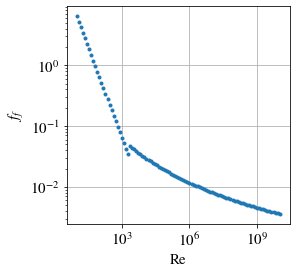

In [4]:
#creando figura y ejes
fig0, ax0 = plt.subplots(figsize=(4,4))
# dibujando un gráfico loglog sobre los ejes
ax0.loglog(Re,f_f,'.',linestyle='')
#grilla
ax0.grid()
#nombre de los ejes
ax0.set_ylabel(r'$f_f$')
ax0.set_xlabel(r'Re');

In [6]:
#Realiza cálculos para distinas rugosidades

Re = np.logspace(1, 10, 200, endpoint=True, base=10)
eD = np.logspace(-7, -2, 10)

Re_m, eD_ = np.meshgrid(Re, eD)
f_f = Re_m * 0
#el array(vector) de salida tiene 2Dimensiones
for j,eD_j in enumerate(eD):
    for i, Re_i in enumerate(Re):
        f_f[j,i] = fluids.friction_factor(Re_i, eD_j)

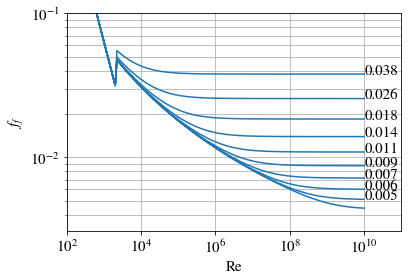

In [7]:
#plot de todas las curvas de friccion
fig1, ax1 = plt.subplots()
lin, = ax1.loglog(Re, f_f[0])
for f_f_i in f_f[1:]:
    ax1.loglog(Re, f_f_i, color=lin.get_color())
    #leyendas "a mano" con el comando "text"
    ax1.text(1e10, f_f_i[-1], f'{f_f_i[-1]:.3f}')
ax1.set_ylabel(r'$f_f$')
ax1.set_xlabel(r'Re')
ax1.set_ylim(top=1e-1)
ax1.set_xlim([100, 1e11])
ax1.grid(which='both', axis='both')

### Problema 

Para determinar si existen pérdidas de agua en un conducto de diámetro d hidraulicamente liso
que atraviesa una montaña se disponen estaciones de medida de presión designadas A-B-C-D.
No se detectan pérdidas de fluido en las partes accesibles AB y CD.

1. Bajo la hipótesis de flujo turbulento a partir de los datos consignados aquí abajo determinar
    las velocidades de flujo entre A y B y entre C y D
2. En el caso que determine que existe una pérdida de agua determinar el caudal de líquido que
    fluye a través de dicha pérdida
3. Determinar la posición de dicha pérdida y la presión del fluído en esa posición.

Datos:

   d=0.05m, L1=1000m, L2=1500m, p_A =600kPa, p_B = 400kPa, p_C =150kPa, p_D =100kPa, ρ=
    1000kg/m$^3$, ν=10$^{–6}$ m$^2$/s.

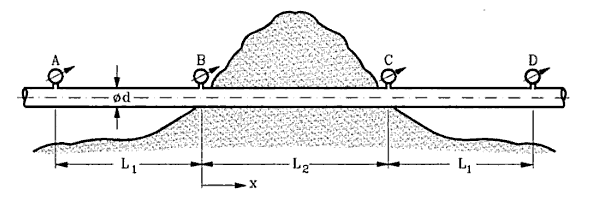

In [6]:
Image('buried_tube.png')

In [11]:
#Datos:

d = 0.05 * ureg.m  #Diámetro caño
L1 = 1000 * ureg.m  #Largo  AB  CD
L2 = 1500 * ureg.m  #Largo BC
p_A, p_B, p_C, p_D = np.array([600, 400, 150, 100]) * ureg.kPa  #Presiones

#Propiedades físicas del Agua
rho = cp.CoolProp.PropsSI('D', 'T', 25 + 273, 'P', 101.3e3,
                          'Water') * ureg.kg * ureg.m**-3
mu = cp.CoolProp.PropsSI('V', 'T', 25 + 273, 'P', 101.3e3,
                         'Water') * ureg.kg * ureg.m**-1 * ureg.sec**-1
nu = mu / rho

In [12]:
#f_f  = fluids.friction_factor(Re_i,eD)

#Caída de presion en un tramo
def caida_fr(U, L, D, rho, mu):
    Re = U * D / mu * rho
    eD = 0
    f_f = fluids.friction_factor(Re, eD)
    delta_p = L / D * f_f * (1 / 2 * rho * U**2)
    return delta_p

#Función para minimizar y encontrar la velocidad en un tramo en el que la pérdida es delta_m
def min_caida(U, L, D, rho, mu, delta_m):
    return (delta_m - caida_fr(U, L, D, rho, mu))

In [18]:
Umin, Umax = [0.1,50] #rango de valores de velocidad para la solución

In [19]:
display(Latex(f'Las variables con unidades se utilizan sin dimensiones en los cálculos complejos'))
display(Latex(f'Entonces, pej $L_1=${L1:.1f}'))
display(Latex(f'Se expresa  L1={L1.magnitude:.1f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

##### a) Velocidades en tramos

In [20]:
#brentq: funcion de la librería scipy.optimize
#para hallar raíces. Se necesita una función objetivo (min_caida), valores mínimos y máximos de búsqueda y argumentos
#de la función objetivo
U_AB = optimize.brentq(min_caida,
                Umin,
                Umax,
                args=(L1.magnitude, d.magnitude, rho.magnitude, mu.magnitude,
                      (p_A - p_B).to(ureg.Pa).magnitude))

U_AB = U_AB*ureg.m*ureg.sec**-1
display(Latex(r'$U_{AB}=$'+f'{U_AB:.2f}'))

U_CD = optimize.brentq(min_caida,
                Umin,
                Umax,
                args=(L1.magnitude, d.magnitude, rho.magnitude, mu.magnitude,
                      (p_C - p_D).to(ureg.Pa).magnitude))

U_CD = U_CD*ureg.m*ureg.sec**-1
display(Latex(r'$U_{CD}=$'+f'{U_CD:.2f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

##### b) Pérdida de caudal

In [21]:
#Área del caño
A_tubo = np.pi*d**2/4 
#caudales de tramos
Q_AB = A_tubo*U_AB
Q_CD = A_tubo*U_CD
#diferencia de caudal --> pérdida
Q_perdida = np.abs(Q_CD - Q_AB)
display(Latex(f'El caudal de fuga es '+r'$Q_f=$'+f'{Q_perdida.to(ureg.liter/ureg.sec):~.2g}'))

<IPython.core.display.Latex object>

##### c) Posición de la pérdida

In [22]:
#perdida en un tubo: primer tramo
U = U_AB.magnitude
x_s = np.arange(0,2500,100)
delta_px = np.zeros_like(x_s)
for i,x_i in enumerate(x_s):
    delta_px[i] = caida_fr(U,x_i,d.magnitude,rho.magnitude,mu.magnitude)
delta_px = delta_px*ureg.Pa    

#perdida en un tubo: ultimo tramo
U = U_CD.magnitude
x_s2 = np.arange(2500,3500,100)
delta_px2 = np.zeros_like(x_s2)
for i,x_i in enumerate(x_s2-x_s2[0]):
    delta_px2[i] = caida_fr(U,x_i,d.magnitude,rho.magnitude,mu.magnitude)
delta_px2 = delta_px2*ureg.Pa  

/home/juan/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/home/juan/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


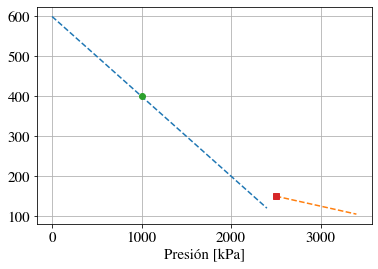

In [29]:
fig2,ax2 = plt.subplots()
ax2.plot(x_s,p_A-delta_px.to(ureg.kPa),linestyle='dashed');
ax2.plot(x_s2,p_C-delta_px2.to(ureg.kPa),linestyle='dashed');
ax2.plot(L1.magnitude,p_B,'o');
ax2.plot(L1.magnitude+L2.magnitude,p_C,'s');
ax2.grid()
ax2.set_xlabel('distancia [m]')
ax2.set_xlabel('Presión [kPa]');
    

/home/juan/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/home/juan/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/home/juan/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


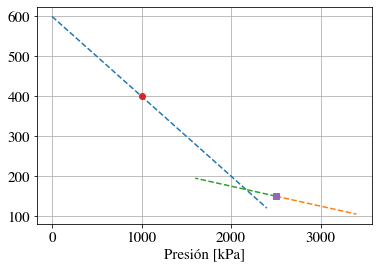

In [30]:
fig3,ax3 = plt.subplots()
ax3.plot(x_s,p_A-delta_px.to(ureg.kPa),linestyle='dashed')
ax3.plot(x_s2,p_C-delta_px2.to(ureg.kPa),linestyle='dashed')
ax3.plot(x_s2[0]+x_s2[0]-x_s2,p_C+delta_px2.to(ureg.kPa),linestyle='dashed')
ax3.plot(L1.magnitude,p_B,'o')
ax3.plot(L1.magnitude+L2.magnitude,p_C,'s')
ax3.grid()
ax3.set_xlabel('distancia [m]')
ax3.set_xlabel('Presión [kPa]');
    

In [110]:
x_s2[0]

2500